In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, log_loss
from sklearn import neighbors, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from mlxtend.evaluate import paired_ttest_5x2cv

# Data set

In [2]:
data = pd.read_csv("iris_dataset.csv")
data.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

# Exploration

## Overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
 4   class        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
data.isnull().sum()

sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64

In [6]:
data.groupby("class").count()

,sepallength,sepalwidth,petallength,petalwidth
class,,,,
Iris-setosa,50,50,50,50
Iris-versicolor,50,50,50,50
Iris-virginica,50,50,50,50


In [7]:
data.describe()

,sepallength,sepalwidth,petallength,petalwidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
corr = data.corr()
corr

,sepallength,sepalwidth,petallength,petalwidth
sepallength,1.000000,-0.109369,0.871754,0.817954
sepalwidth,-0.109369,1.000000,-0.420516,-0.356544
petallength,0.871754,-0.420516,1.000000,0.962757
petalwidth,0.817954,-0.356544,0.962757,1.000000


## Plots

<AxesSubplot:xlabel='petalwidth', ylabel='Count'>

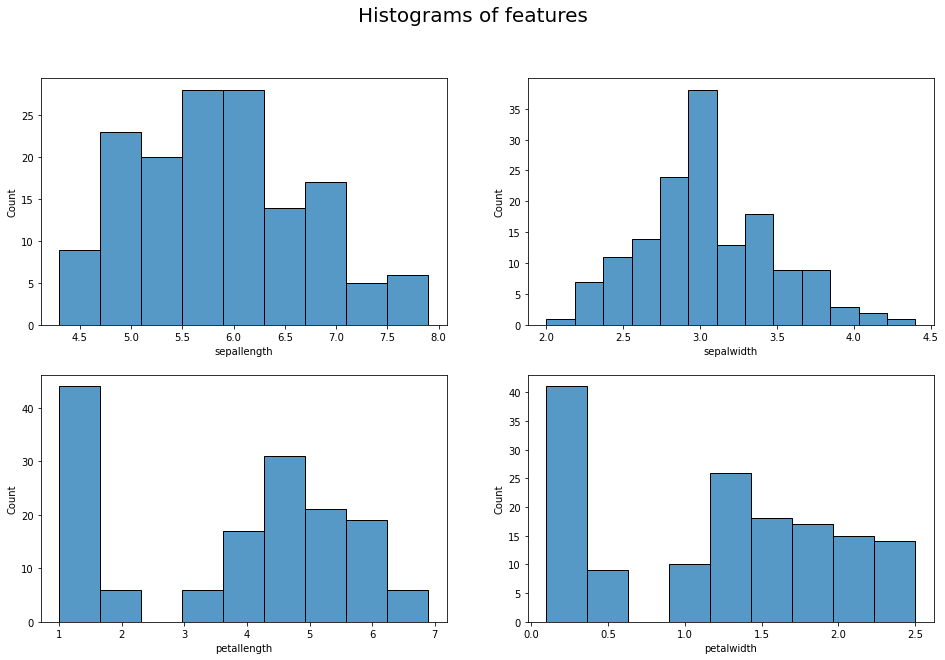

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle("Histograms of features", fontsize=20)
sns.histplot(data=data["sepallength"], ax=axs[0, 0])
sns.histplot(data=data["sepalwidth"], ax=axs[0, 1])
sns.histplot(data=data["petallength"], ax=axs[1, 0])
sns.histplot(data=data["petalwidth"], ax=axs[1, 1])

<AxesSubplot:>

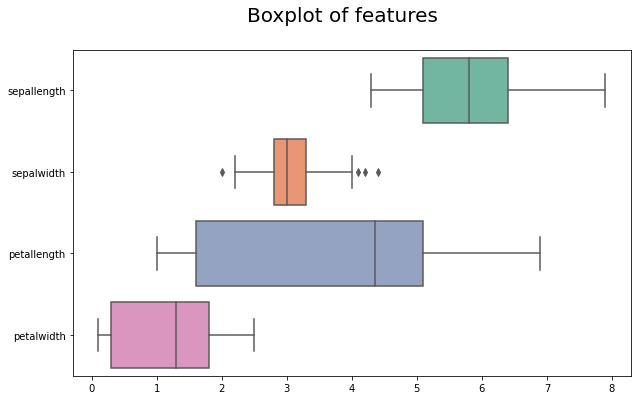

In [10]:
fig, axs = plt.subplots(figsize=(10, 6))
fig.suptitle("Boxplot of features", fontsize=20)
sns.boxplot(data=X, orient="h", palette="Set2")

<AxesSubplot:>

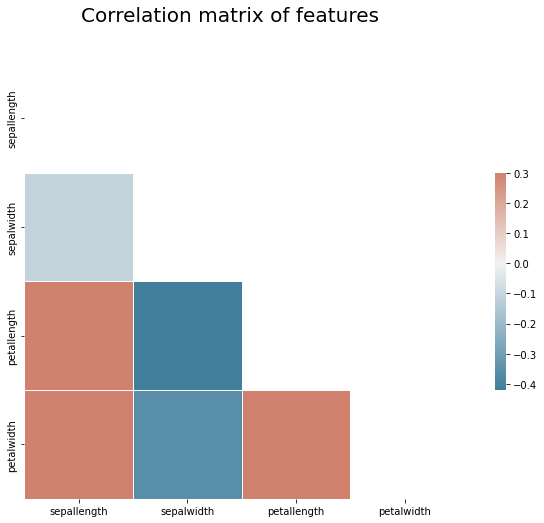

In [11]:
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, axs = plt.subplots(figsize=(13, 8))
fig.suptitle("Correlation matrix of features", fontsize=20)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='class', ylabel='petalwidth'>

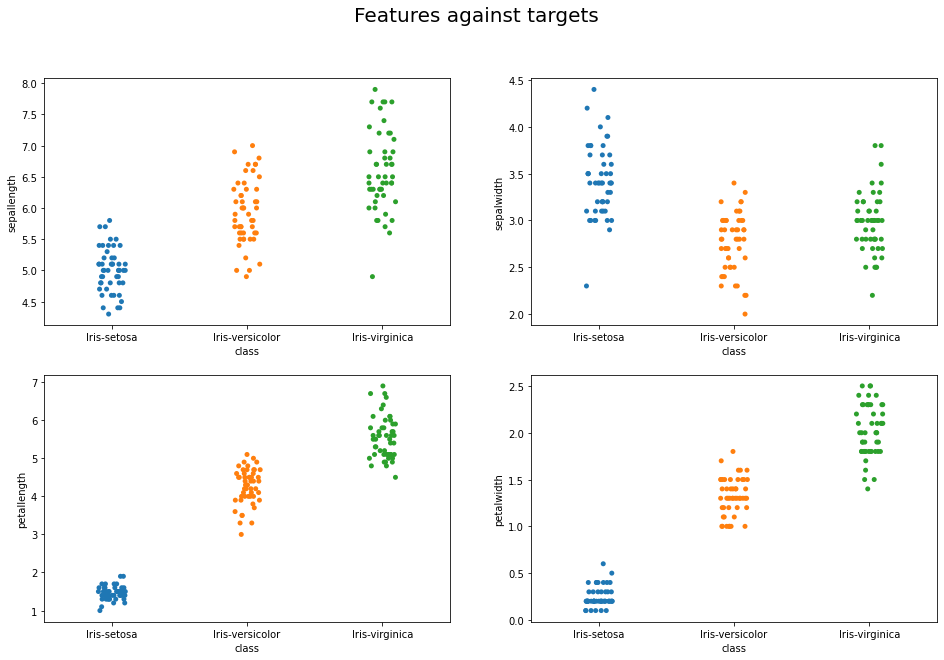

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle("Features against targets", fontsize=20)
sns.stripplot(data=data, x="class", y="sepallength", ax=axs[0, 0])
sns.stripplot(data=data, x="class", y="sepalwidth", ax=axs[0, 1])
sns.stripplot(data=data, x="class", y="petallength", ax=axs[1, 0])
sns.stripplot(data=data, x="class", y="petalwidth", ax=axs[1, 1])

# Pre-processing

## Feature selection

In [13]:
# not needed

## Feature scaling

In [14]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Encoding

In [15]:
enc = LabelEncoder()
y_encoded = enc.fit_transform(y.values.ravel())

# Model selection

In [16]:
# [TODO] add grid search for each class

## K-Nearest Neighbor

In [17]:
knn = {
    # [n_neighbors, weights]
    "KNN [5, uniform]": neighbors.KNeighborsClassifier(n_neighbors=5),
    "KNN [5, distance]": neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance"),
    "KNN [1, uniform]": neighbors.KNeighborsClassifier(n_neighbors=1),
    "KNN [1, distance]": neighbors.KNeighborsClassifier(n_neighbors=1, weights="distance"),
    "KNN [3, uniform]": neighbors.KNeighborsClassifier(n_neighbors=3),
    "KNN [3, distance]": neighbors.KNeighborsClassifier(n_neighbors=3, weights="distance"),    
    #"KNN [10, uniform]": neighbors.KNeighborsClassifier(n_neighbors=10),
    #"KNN [10, distance]": neighbors.KNeighborsClassifier(n_neighbors=10, weights="distance"),
    #"KNN [15, uniform]": neighbors.KNeighborsClassifier(n_neighbors=15),
    #"KNN [15, distance]": neighbors.KNeighborsClassifier(n_neighbors=15, weights="distance")
}


## Decision Tree

In [18]:
# either Decision tree or Random Forest -> both tree search algorithms

rnd = 5
decision_tree = {
    # [criterion, splitter, max_depth]
    "Decision Tree [gini, best, none]": DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None, random_state=rnd),
    "Decision Tree [entropy, best, none]": DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=None, random_state=rnd),
    "Decision Tree [gini, random, none]": DecisionTreeClassifier(criterion="gini", splitter="random", max_depth=None, random_state=rnd),
    "Decision Tree [gini, best, 5]": DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=5, random_state=rnd),
    "Decision Tree [entropy, best, 5]": DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=5, random_state=rnd),
    "Decision Tree [gini, random, 5]": DecisionTreeClassifier(criterion="gini", splitter="random", max_depth=5, random_state=rnd),
    #"Decision Tree [gini, best, 10]": DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=10, random_state=rnd),
    #"Decision Tree [entropy, best, 10]": DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=10, random_state=rnd),
    #"Decision Tree [gini, random, 10]": DecisionTreeClassifier(criterion="gini", splitter="random", max_depth=10, random_state=rnd)
}

## Random Forest

In [19]:
# either Decision tree or Random Forest -> both tree search algorithms

rnd = 5
random_forest = {
    # [n_estimators, criterion, max_depth]
    "Random Forest [100, gini, none]": RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, random_state=rnd),
    "Random Forest [200, gini, none]": RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=None, random_state=rnd),
    #"Random Forest [300, gini, none]": RandomForestClassifier(n_estimators=300, criterion="gini", max_depth=None, random_state=rnd),
    "Random Forest [100, entropy, none]": RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=None, random_state=rnd),
    "Random Forest [200, entropy, none]": RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=None, random_state=rnd),
    #"Random Forest [300, entropy, none]": RandomForestClassifier(n_estimators=300, criterion="entropy", max_depth=None, random_state=rnd),
    "Random Forest [100, gini, 5]": RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=5, random_state=rnd),
    "Random Forest [200, gini, 5]": RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=5, random_state=rnd),
    #"Random Forest [300, gini, 5]": RandomForestClassifier(n_estimators=300, criterion="gini", max_depth=5, random_state=rnd),
    "Random Forest [100, entropy, 5]": RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, random_state=rnd),
    "Random Forest [200, entropy, 5]": RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=5, random_state=rnd),
    #"Random Forest [300, entropy, 5]": RandomForestClassifier(n_estimators=300, criterion="entropy", max_depth=5, random_state=rnd)
}

## Support Vector Machines

In [20]:
svm = {
    # [regularization, gamma]
    "SVM [1, scale]": svm.SVC(C=1.0, gamma="scale"),
    "SVM [0.1, scale]": svm.SVC(C=0.1, gamma="scale"),
    "SVM [10, scale]": svm.SVC(C=10.0, gamma="scale"),
    "SVM [100, scale]": svm.SVC(C=100.0, gamma="scale"),
    "SVM [1, 1]": svm.SVC(C=1.0, gamma=1.0),
    "SVM [0.1, 1]": svm.SVC(C=0.1, gamma=1.0),
    "SVM [10, 1]": svm.SVC(C=10.0, gamma=1.0),
    "SVM [100, 1]": svm.SVC(C=100.0, gamma=1.0),
}

In [21]:
classifiers = [knn, random_forest, svm]


# Training and validation

In [22]:
# [TODO] add and plot confusion matrix:
# plt.figure(figsize = (10,7))
# sns.heatmap(conf_matrix, annot=True)

## Hold-out

In [23]:
def holdout(clf, X_train, y_train, test_size):
    start = timeit.default_timer()

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=30)
    model = clf.fit(X_train, y_train)

    accuracy = accuracy_score(y_val, model.predict(X_val))
    recall = recall_score(y_val, model.predict(X_val), average="macro")
    f1 = f1_score(y_val, model.predict(X_val), average="macro")

    stop = timeit.default_timer()
    runtime = stop - start

    return([accuracy, recall, f1, runtime, model])

## Cross-validation

In [24]:
def cross_validation(clf, X_train, y_train, cv):
    start = timeit.default_timer()
    
    model = clf.fit(X_train, y_train)

    accuracy = cross_val_score(model, X=X_train, y=y_train, scoring="accuracy", cv=cv)
    recall = cross_val_score(model, X=X_train, y=y_train, scoring="recall_macro", cv=cv)
    f1 = cross_val_score(model, X=X_train, y=y_train, scoring="f1_macro", cv=cv)

    stop = timeit.default_timer()
    runtime = stop - start

    return([np.mean(accuracy), np.mean(recall), np.mean(f1), runtime, model])


# Results

In [25]:
def evaluate_classifiers(classifiers, X_train, y_train):
    performance = list()
    significance = list()

    for clf_dict in classifiers:
        baseline = clf_dict[list(clf_dict.keys())[0]]   # set first classifier of each class as baseline
        baseline.fit(X_train, y_train)
        
        for i, (key, clf) in enumerate(clf_dict.items()):
            # significance test against default settings -> error messages are normal, because baseline gets tested against itself -> NAs
            _, p_accuracy = paired_ttest_5x2cv(estimator1=baseline, estimator2=clf, X=X_train, y=y_train, scoring="accuracy", random_seed=30)
            _, p_recall = paired_ttest_5x2cv(estimator1=baseline, estimator2=clf, X=X_train, y=y_train, scoring="recall_macro", random_seed=30)
            _, p_f1 = paired_ttest_5x2cv(estimator1=baseline, estimator2=clf, X=X_train, y=y_train, scoring="f1_macro", random_seed=30)
            significance.append([key, p_accuracy, p_recall, p_f1])

            # hold-out
            for test_size in [0.2, 0.3, 0.4]:
                accuracy, recall, f1, runtime, model = holdout(clf, X_train, y_train, test_size=test_size)
                performance.append([key, "hold-out", test_size, accuracy, recall, f1, runtime, model])
                
            # cross-validation
            for cv in [3, 5, 10]:
                accuracy, recall, f1, runtime, model = cross_validation(clf, X_train, y_train, cv)
                performance.append([key, "cross", cv, accuracy, recall, f1, runtime, model])

    return(list([performance, significance]))

results = evaluate_classifiers(classifiers, X_scaled, y_encoded)
performance_df = pd.DataFrame(results[0], columns=["Classifier", "Validation", "Split", "Accuracy", "Recall (macro)", "F1 (macro)", "Runtime", "Model"])
performance_df.drop("Model", axis=1, inplace=True)
significance_df = pd.DataFrame(results[1], columns=["Classifier", "Accuracy", "Recall (macro)", "F1 (macro)"])

f:\Programmieren\Python\ml-projects\.venv\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator
f:\Programmieren\Python\ml-projects\.venv\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator
f:\Programmieren\Python\ml-projects\.venv\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator
f:\Programmieren\Python\ml-projects\.venv\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator
f:\Programmieren\Python\ml-projects\.venv\lib\site-packages\mlxtend\evaluate\ttest.py:333: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator
f:\Programmieren\Python\ml-projects\.venv\lib\site-packages\mlxtend\ev

In [28]:
performance_df

,Classifier,Validation,Split,Accuracy,Recall (macro),F1 (macro),Runtime
0,"KNN [5, uniform]",hold-out,0.2,0.900000,0.888889,0.888545,0.004528
1,"KNN [5, uniform]",hold-out,0.3,0.933333,0.931174,0.934359,0.004894
2,"KNN [5, uniform]",hold-out,0.4,0.916667,0.927778,0.924203,0.005664
3,"KNN [5, uniform]",cross,3.0,0.960000,0.959967,0.960136,0.020094
4,"KNN [5, uniform]",cross,5.0,0.960000,0.960000,0.959832,0.027274
...,...,...,...,...,...,...,...
181,"Random Forest [300, entropy, 5]",hold-out,0.3,0.933333,0.939271,0.935936,0.281775
182,"Random Forest [300, entropy, 5]",hold-out,0.4,0.966667,0.972222,0.969634,0.279167
183,"Random Forest [300, entropy, 5]",cross,3.0,0.960000,0.959559,0.959893,2.347227
184,"Random Forest [300, entropy, 5]",cross,5.0,0.953333,0.953333,0.953115,3.788661


In [29]:
significance_df

,Classifier,Accuracy,Recall (macro),F1 (macro)
0,"KNN [5, uniform]",NaN,NaN,NaN
1,"KNN [5, distance]",1.000000,1.000000,1.000000
2,"KNN [1, uniform]",0.500680,0.495651,0.529347
3,"KNN [1, distance]",0.500680,0.495651,0.529347
4,"KNN [3, uniform]",0.520868,0.562158,0.529656
5,"KNN [3, distance]",0.582570,0.616615,0.584215
6,"KNN [10, uniform]",0.159558,0.162276,0.155012
7,"KNN [10, distance]",0.063817,0.079997,0.070069
8,"KNN [15, uniform]",0.715143,0.734337,0.714845
9,"KNN [15, distance]",1.000000,1.000000,1.000000


In [32]:
significance_df["Accuracy"<0.05]

TypeError: '<' not supported between instances of 'str' and 'float'